# 1) Comparar a performance de 𝑘NN e de Naïve Bayes com suposição Gaussiana

In [210]:
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Read ARFF file
data = loadarff('column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

X = df.drop('class', axis=1)
y = df['class']

stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

knn_accuracies, nb_accuracies = [], []

knn_classifier = KNeighborsClassifier(n_neighbors=5)
nb_classifier = GaussianNB()

# Iterate through each fold of stratified cross-validation
for train_index, test_index in stratified_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train both classifiers
    knn_classifier.fit(X_train, y_train)
    nb_classifier.fit(X_train, y_train)
    
    # Predict and evaluate 𝑘NN
    knn_pred = knn_classifier.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    knn_accuracies.append(knn_accuracy)
    
    # Predict and evaluate Gaussian Naïve Bayes
    nb_pred = nb_classifier.predict(X_test)
    nb_accuracy = accuracy_score(y_test, nb_pred)
    nb_accuracies.append(nb_accuracy)

### a) Boxplots das precisões de cada classificador

C:\Users\diogo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 119896 (\N{MATHEMATICAL ITALIC SMALL K}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


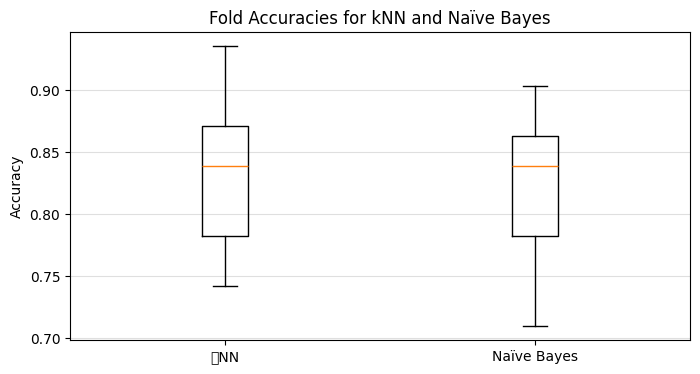

In [211]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.boxplot([knn_accuracies, nb_accuracies], labels=['𝑘NN', 'Naïve Bayes'])
plt.title('Fold Accuracies for kNN and Naïve Bayes')
plt.ylabel('Accuracy')
plt.grid(axis='y', alpha=0.4)
plt.show()

### b) Testar a hipótese “𝑘NN is statistically superior to naïve Bayes regarding accuracy”

In [212]:
from scipy import stats

# H0: 𝑘NN is statistically equal to Naïve Bayes regarding accuracy
# H1: 𝑘NN is statistically superior to Naïve Bayes regarding accuracy
t_statistic, p_value = stats.ttest_rel(knn_accuracies, nb_accuracies, alternative='greater')

alpha = 0.05  # Significance level
if p_value < alpha:
    print('Para níveis de signicância até 0.05, a hipótese nula (𝑘NN é estatisticamente igual a Naïve Bayes em termos de precisão)'
          '\né rejeitada, ou seja, "𝑘NN is statistically superior to Naïve Bayes regarding accuracy" confirma-se.')
else:
    print('Para níveis de signicância até 0.05, a hipótese nula (𝑘NN é estatisticamente igual a Naïve Bayes em termos de precisão)',
          '\nnão pode ser rejeitada, ou seja, "𝑘NN is statistically superior to Naïve Bayes regarding accuracy" é falso.')

Para níveis de signicância até 0.05, a hipótese nula (𝑘NN é estatisticamente igual a Naïve Bayes em termos de precisão) 
não pode ser rejeitada, ou seja, "𝑘NN is statistically superior to Naïve Bayes regarding accuracy" é falso.


# 2) Diferença das matrizes de confusão cumulativas de 2 preditores 𝑘NN

In [213]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Initialize lists to store confusion matrices
cmatrices_knn1, cmatrices_knn5 = [], []
classes = ["Hernia", "Normal", "Spondylolisthesis"]

knn1 = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')
knn5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

# Iterate through each fold of stratified cross-validation
for train_index, test_index in stratified_cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train both classifiers    
    knn1.fit(X_train, y_train)
    knn5.fit(X_train, y_train)

    # Make predictions and calculate confusion matrix for 𝑘NN1
    y_pred_knn1 = knn1.predict(X_test)
    cmatrix_knn1 = confusion_matrix(y_test, y_pred_knn1, labels=classes)
    cmatrices_knn1.append(cmatrix_knn1)

    # Make predictions and calculate confusion matrix for 𝑘NN5
    y_pred_knn5 = knn5.predict(X_test)
    cmatrix_knn5 = confusion_matrix(y_test, y_pred_knn5, labels=classes)
    cmatrices_knn5.append(cmatrix_knn5)

mean_knn1 = np.mean(cmatrices_knn1, axis=0)
mean_knn5 = np.mean(cmatrices_knn5, axis=0)

cumulative_knn1 = np.cumsum(mean_knn1, axis=0)
cumulative_knn5 = np.cumsum(mean_knn5, axis=0)

# Calculate the difference between cumulative confusion matrices
difference_matrix = cumulative_knn1 - cumulative_knn5

print("Difference between cumulative confusion matrices (𝑘NN1 - 𝑘NN5):\n\n",
      pd.DataFrame(difference_matrix, index=classes, columns=classes),
      "\n\nNote:\tColumns are predicted values\n\tLines are test values")

Difference between cumulative confusion matrices (𝑘NN1 - 𝑘NN5):

                    Hernia  Normal  Spondylolisthesis
Hernia               -0.2     0.2                0.0
Normal               -0.7     0.4                0.3
Spondylolisthesis    -0.7     0.5                0.2 

Note:	Columns are predicted values
	Lines are test values


### Comment results of 2)

# 3) Possíveis dificuldades de Naïve Bayes a aprender o dataset column_diagnosis

Comment